<a href="https://colab.research.google.com/github/gankidisaicharan/Attendance_system_using_Face_detection_and_recognition/blob/main/Face_Detection_and_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Install necessary libraries
!pip install gradio
!pip install torch torchvision
!pip install opencv-python
!pip install mtcnn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.2 MB/s eta 0:00:00


In [4]:
import pathlib
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [5]:
file_path = '/content/drive/MyDrive/PROJECTS/face detection and recognition/Indian_actors_faces'
data_dir = pathlib.Path(file_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)#students names

['abhay_deol' 'adil_hussain' 'ajay_devgn' 'akshay_kumar' 'akshaye_khanna'
 'amitabh_bachchan' 'amjad_khan' 'amol_palekar' 'amole_gupte'
 'amrish_puri' 'anil_kapoor' 'annu_kapoor' 'anupam_kher' 'anushka_shetty'
 'arshad_warsi' 'aruna_irani' 'ashish_vidyarthi' 'asrani' 'atul_kulkarni'
 'ayushmann_khurrana' 'boman_irani' 'chiranjeevi' 'chunky_panday'
 'danny_denzongpa' 'darsheel_safary' 'deepika_padukone' 'deepti_naval'
 'dev_anand' 'dharmendra' 'dilip_kumar' 'dimple_kapadia' 'farhan_akhtar'
 'farida_jalal' 'farooq_shaikh' 'girish_karnad' 'govinda' 'gulshan_grover'
 'hrithik_roshan' 'huma_qureshi' 'irrfan_khan' 'jaspal_bhatti' 'jeetendra'
 'jimmy_sheirgill' 'johnny_lever' 'kader_khan' 'kajol' 'kalki_koechlin'
 'kamal_haasan' 'kangana_ranaut' 'kay_kay_menon' 'konkona_sen_sharma'
 'kulbhushan_kharbanda' 'lara_dutta' 'madhavan' 'madhuri_dixit'
 'mammootty' 'manoj_bajpayee' 'manoj_pahwa' 'mehmood' 'mita_vashisht'
 'mithun_chakraborty' 'mohanlal' 'mohnish_bahl' 'mukesh_khanna'
 'mukul_dev' 'na

In [6]:
len(class_names)# total no of students

135

In [7]:
import os
main_folder_path = file_path
for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)
    if os.path.isdir(folder_path):
        images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f'There are {len(images)} images of \'{os.path.basename(folder_path)}\'.')

There are 47 images of 'ranbir_kapoor'.
There are 41 images of 'shah_rukh_khan'.
There are 45 images of 'nagarjuna_akkineni'.
There are 44 images of 'atul_kulkarni'.
There are 38 images of 'rajit_kapoor'.
There are 34 images of 'amol_palekar'.
There are 49 images of 'nandita_das'.
There are 47 images of 'rajpal_yadav'.
There are 36 images of 'asrani'.
There are 49 images of 'tabu'.
There are 45 images of 'rajesh_khanna'.
There are 46 images of 'jeetendra'.
There are 43 images of 'rajat_kapoor'.
There are 43 images of 'abhay_deol'.
There are 45 images of 'soumitra_chatterjee'.
There are 44 images of 'nana_patekar'.
There are 43 images of 'arshad_warsi'.
There are 37 images of 'rekha'.
There are 50 images of 'madhavan'.
There are 46 images of 'radhika_apte'.
There are 44 images of 'sharman_joshi'.
There are 50 images of 'naseeruddin_shah'.
There are 45 images of 'ranveer_singh'.
There are 48 images of 'kamal_haasan'.
There are 47 images of 'vidya_balan'.
There are 47 images of 'pawan_mal

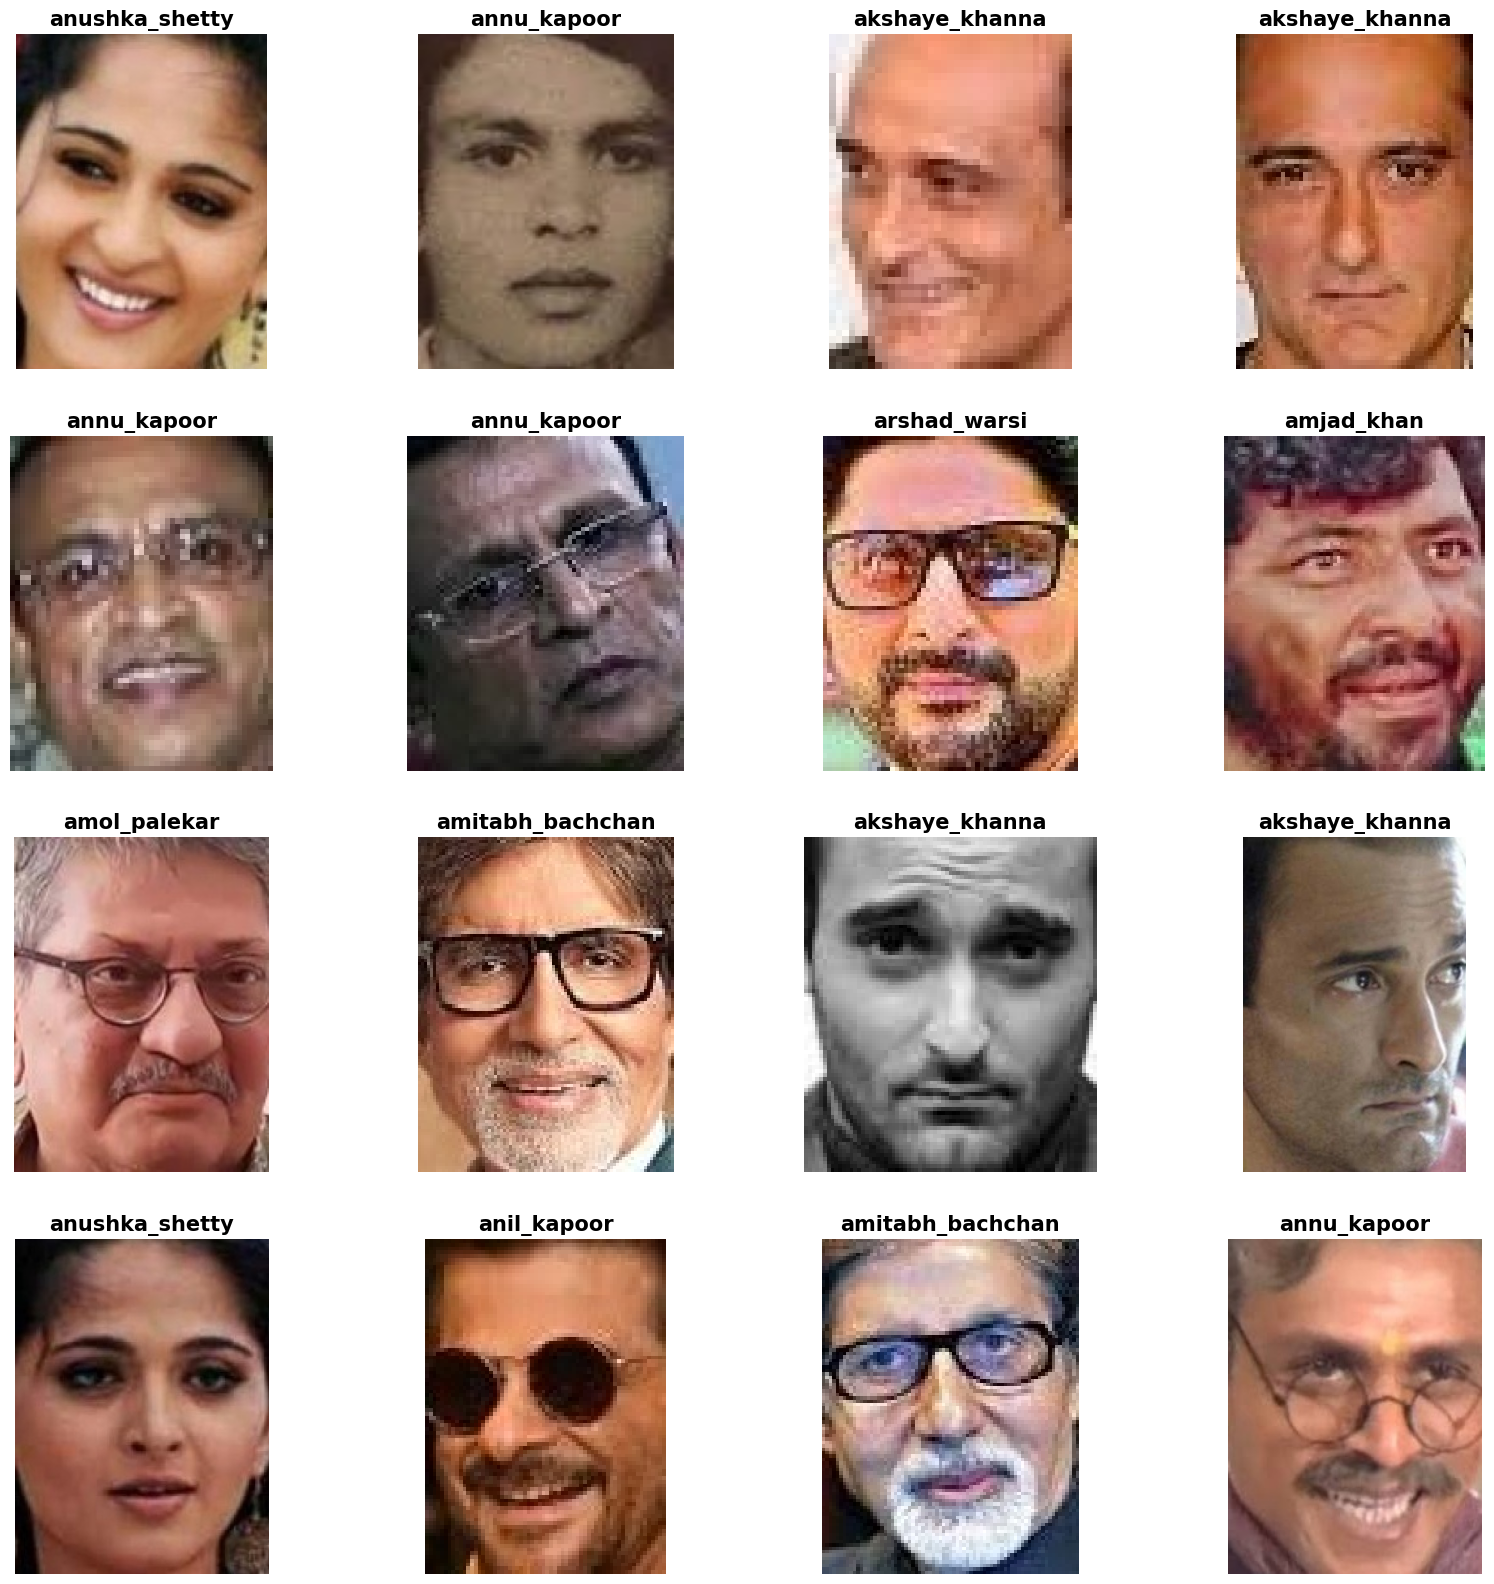

In [8]:
plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    random_class = random.randint(0, 14)
    folder_path = file_path + '/' + class_names[random_class]
    random_image_path = folder_path + '/' + (random.sample(os.listdir(folder_path), 1)[0])
    image = plt.imread(random_image_path)
    plt.axis('off')
    plt.title(class_names[random_class], fontsize = 15, fontweight = 'bold')
    plt.imshow(image)

#Step 1: Data Pre-processing and Augmentation

Data Augmentation

In [13]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

# Define transformations with data augmentation for training data
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((160, 160)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(15),
    transforms.RandomGrayscale(p=0.1),
    # [Additional custom transforms like noise, cutout, etc.],
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Simpler transformations for validation data (no augmentation, just resizing and normalization)
val_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Data Loading

In [14]:
# Load data using ImageFolder
full_data = ImageFolder(root=data_dir, transform=train_transform)  # Apply transformations

# Split data into training and validation
train_size = int(0.8 * len(full_data))
val_size = len(full_data) - train_size
train_data, val_data = random_split(full_data, [train_size, val_size])

# Update transform for validation data (after the split)
val_data.dataset.transform = val_transform

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


Counter({53: 44, 69: 42, 62: 42, 133: 41, 51: 41, 109: 41, 95: 41, 126: 41, 67: 41, 28: 40, 78: 40, 72: 40, 11: 40, 50: 40, 21: 40, 132: 40, 64: 40, 47: 40, 3: 39, 103: 39, 122: 39, 34: 39, 26: 39, 42: 39, 60: 39, 39: 39, 46: 38, 1: 38, 48: 38, 61: 38, 113: 38, 106: 38, 90: 38, 131: 38, 31: 38, 23: 38, 129: 37, 55: 37, 100: 37, 77: 37, 37: 37, 71: 37, 97: 37, 41: 37, 83: 37, 38: 37, 18: 37, 124: 37, 76: 37, 24: 37, 86: 37, 111: 37, 4: 37, 12: 37, 107: 36, 98: 36, 115: 36, 0: 36, 87: 36, 43: 36, 19: 36, 121: 36, 15: 36, 91: 36, 89: 36, 130: 36, 45: 36, 52: 36, 80: 36, 114: 36, 27: 36, 49: 36, 82: 36, 108: 36, 112: 35, 123: 35, 56: 35, 81: 35, 8: 35, 36: 35, 125: 35, 116: 35, 44: 34, 58: 34, 88: 34, 14: 34, 127: 34, 20: 34, 57: 34, 128: 34, 99: 34, 134: 34, 101: 34, 2: 34, 119: 34, 66: 34, 65: 34, 73: 33, 33: 33, 63: 33, 96: 33, 25: 33, 29: 33, 54: 33, 102: 33, 118: 33, 92: 33, 75: 33, 40: 33, 85: 33, 30: 33, 35: 32, 120: 32, 117: 32, 84: 32, 5: 32, 93: 31, 32: 31, 16: 31, 79: 31, 74: 31

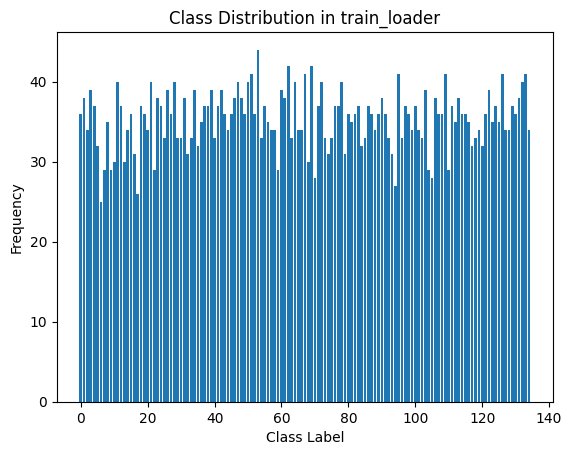

In [15]:
import collections
import matplotlib.pyplot as plt

# Initialize a counter.
counter = collections.Counter()

# Loop through the train loader.
for _, labels in train_loader:
    # Update the counter.
    counter.update(labels.numpy())

# Analyze distribution.
print(counter)

# Visualization (optional)
plt.bar(counter.keys(), counter.values())
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Class Distribution in train_loader')
plt.show()


In [16]:
# Extracting the counts and computing class weights
class_counts = list(counter.values())

#Step 2: Model Definition

In [17]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load pre-trained model and adjust final layer
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 135)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 60.1MB/s]


In [18]:
# Sample forward pass
with torch.no_grad():
    model.eval()  # Set model to evaluation mode
    sample_input = torch.randn(1, 3, 160, 160).to(device)  # Create a random tensor with appropriate dimensions
    sample_output = model(sample_input)  # Forward pass
    print(f"Output shape: {sample_output.shape}")  # Should be [1, 135]


Output shape: torch.Size([1, 135])


#Step 3: Model Training

In [ ]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import autocast, GradScaler
from tqdm.notebook import tqdm

# Calculate class weights
class_weights = [sum(class_counts) / c for c in class_counts]
class_weights_normalized = [float(i)/sum(class_weights) for i in class_weights]
class_weights_tensor = torch.tensor(class_weights_normalized).cuda()

# 3.1 Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)  # Learning Rate Scheduler

In [ ]:
scaler = GradScaler()

In [ ]:
# Training parameters
num_epochs = 15  # You might want to use a different number
accumulation_steps = 2  # Gradient Accumulation steps

In [ ]:
from tqdm.notebook import tqdm

# Lists to store accuracy values for each epoch
train_acc_list = []
val_acc_list = []

# Function to compute accuracy
def compute_accuracy(model, data_loader, device):
    correct_preds, num_examples = 0, 0
    model.eval()
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted_labels = torch.max(outputs, 1)
        num_examples += labels.size(0)
        correct_preds += (predicted_labels == labels).sum()
    return correct_preds.float()/num_examples * 100

# Training loop
for epoch in tqdm(range(num_epochs), desc='Epochs', unit='epoch'):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Variable i is not defined in the provided loop, so adding a loop variable here
    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc='Batch', unit='batch', leave=False)):
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU

        optimizer.zero_grad()  # Zero the parameter gradients

        # Using mixed precision
        with torch.cuda.amp.autocast():
            outputs = model(inputs)  # Forward-pass
            loss = criterion(outputs, labels)  # Compute loss

        # Gradient Accumulation
        scaler.scale(loss).backward()
        if (i+1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * inputs.size(0)

    scheduler.step()  # Step the learning rate scheduler
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}", flush=True)

    # Compute and store training accuracy
    train_accuracy = compute_accuracy(model, train_loader, device)
    train_acc_list.append(train_accuracy)

    # Compute and store validation accuracy
    val_accuracy = compute_accuracy(model, val_loader, device)
    val_acc_list.append(val_accuracy)
    print(f"Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")


    # 3.3 Validate the Model [Optional: Within Epoch Loop]
    # Implement validation loop similar to training, but no backward-pass and weight updates. Compute metrics as needed.

# 3.4 Save the Model
torch.save(model.state_dict(), 'model.pth')

Epochs:   0%|          | 0/15 [00:00<?, ?epoch/s]

Batch:   0%|          | 0/150 [00:00<?, ?batch/s]

Epoch 1/15, Loss: 4.5927
Training Accuracy: 17.19%, Validation Accuracy: 13.31%


Batch:   0%|          | 0/150 [00:00<?, ?batch/s]

Epoch 2/15, Loss: 3.0470
Training Accuracy: 41.89%, Validation Accuracy: 30.13%


Batch:   0%|          | 0/150 [00:00<?, ?batch/s]

Epoch 3/15, Loss: 1.9076
Training Accuracy: 65.04%, Validation Accuracy: 46.78%


Batch:   0%|          | 0/150 [00:00<?, ?batch/s]

Epoch 4/15, Loss: 1.2153
Training Accuracy: 85.24%, Validation Accuracy: 60.17%


Batch:   0%|          | 0/150 [00:00<?, ?batch/s]

Epoch 5/15, Loss: 0.7259
Training Accuracy: 89.11%, Validation Accuracy: 64.02%


Batch:   0%|          | 0/150 [00:00<?, ?batch/s]

Epoch 6/15, Loss: 0.4661
Training Accuracy: 95.00%, Validation Accuracy: 69.96%


Batch:   0%|          | 0/150 [00:00<?, ?batch/s]

Epoch 7/15, Loss: 0.2450
Training Accuracy: 97.68%, Validation Accuracy: 72.30%


Batch:   0%|          | 0/150 [00:00<?, ?batch/s]

Epoch 8/15, Loss: 0.1266
Training Accuracy: 99.02%, Validation Accuracy: 75.56%


Batch:   0%|          | 0/150 [00:00<?, ?batch/s]

Epoch 9/15, Loss: 0.0787
Training Accuracy: 99.46%, Validation Accuracy: 76.82%


Batch:   0%|          | 0/150 [00:00<?, ?batch/s]

Epoch 10/15, Loss: 0.0636
Training Accuracy: 99.60%, Validation Accuracy: 77.57%


Batch:   0%|          | 0/150 [00:00<?, ?batch/s]

Epoch 11/15, Loss: 0.0513
Training Accuracy: 99.67%, Validation Accuracy: 77.57%


Batch:   0%|          | 0/150 [00:00<?, ?batch/s]

Epoch 12/15, Loss: 0.0432
Training Accuracy: 99.87%, Validation Accuracy: 78.49%


Batch:   0%|          | 0/150 [00:00<?, ?batch/s]

Epoch 13/15, Loss: 0.0349
Training Accuracy: 99.92%, Validation Accuracy: 79.25%


Batch:   0%|          | 0/150 [00:00<?, ?batch/s]

Epoch 14/15, Loss: 0.0314
Training Accuracy: 99.96%, Validation Accuracy: 78.74%


Batch:   0%|          | 0/150 [00:00<?, ?batch/s]

Epoch 15/15, Loss: 0.0268
Training Accuracy: 99.96%, Validation Accuracy: 78.49%


# Step 4: Model Evaluation.

In [19]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 135)  # Assuming you have 135 classes
model.load_state_dict(torch.load('/content/drive/MyDrive/PROJECTS/face detection and recognition/model/model.pth'))  # Load trained weights
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Variables to store predictions and labels
all_preds = []
all_labels = []

# No gradient computation needed during inference
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward-pass and store predictions and labels
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



In [20]:
# 4.2 Model Metrics
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Classification Report:
                      precision    recall  f1-score   support

          abhay_deol       1.00      1.00      1.00         7
        adil_hussain       1.00      1.00      1.00        10
          ajay_devgn       0.89      0.89      0.89         9
        akshay_kumar       1.00      1.00      1.00         9
      akshaye_khanna       1.00      1.00      1.00         8
    amitabh_bachchan       1.00      1.00      1.00        12
          amjad_khan       1.00      1.00      1.00         4
        amol_palekar       1.00      0.80      0.89         5
         amole_gupte       1.00      1.00      1.00         6
         amrish_puri       1.00      1.00      1.00        12
         anil_kapoor       0.83      0.71      0.77         7
         annu_kapoor       1.00      1.00      1.00         4
         anupam_kher       1.00      0.83      0.91         6
      anushka_shetty       1.00      1.00      1.00         9
        arshad_warsi       1.00      1.00     

In [21]:
# 4.3 Confusion Matrix
conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(150, 150))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


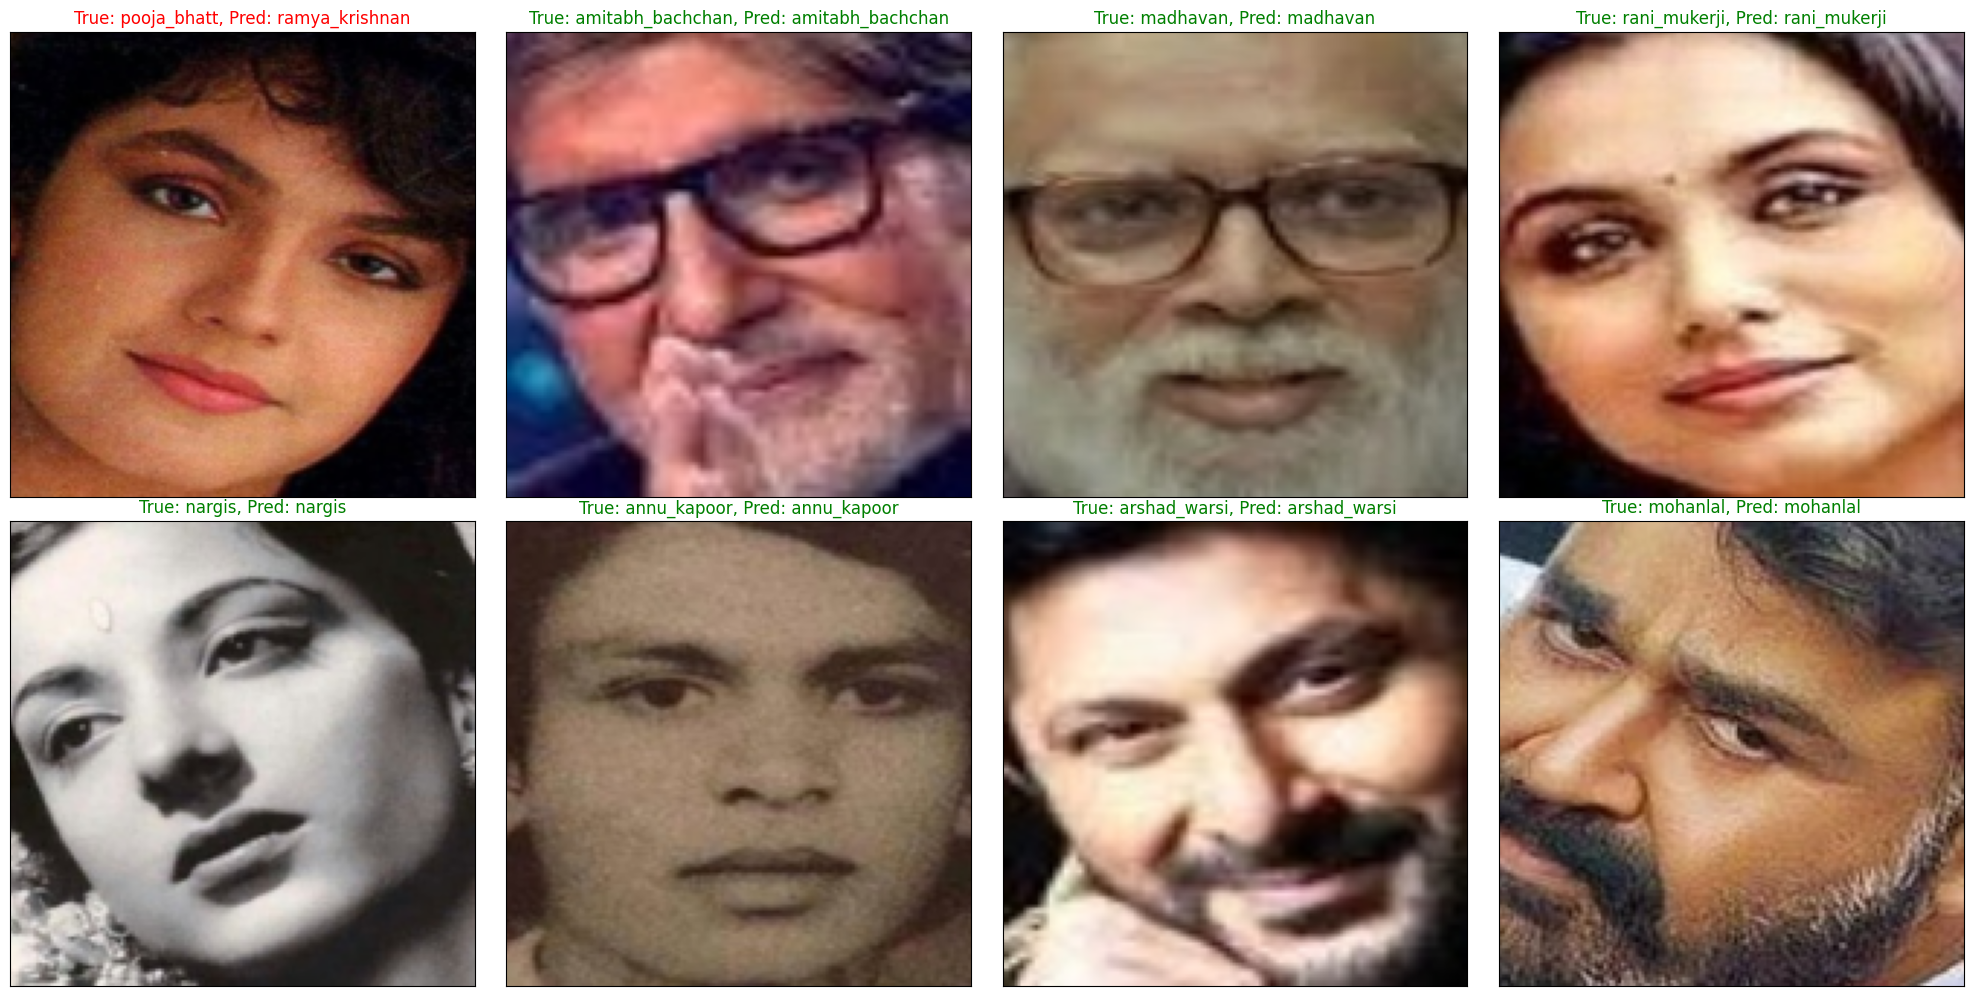

In [22]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import random

# Assuming `validation_loader` is your DataLoader object for the validation set
# and it does not shuffle the data (important to keep data and labels in order)

# Getting a batch of data
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

# Ensure the model is in evaluation mode
model.eval()

# No gradients needed for inference
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Inverse normalization of images for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# Let's visualize a few predictions
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10),  # Adjusted figsize
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image, label, pred = images[i], labels[i], preds[i]

    # Inverse normalization
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    image_inv = inv_normalize(image)

    # Convert image from GPU to CPU and from Tensor to Numpy array
    image_np = image_inv.cpu().detach().numpy().transpose((1, 2, 0))

    # Clip image data to [0, 1] to avoid warnings and make it displayable
    image_np = np.clip(image_np, 0, 1)

    # Display image with true and predicted labels
    ax.imshow(image_np)
    ax.set_title(f"True: {class_names[label]}, Pred: {class_names[pred]}",
             color=("green" if label == pred else "red"), fontsize=12)


plt.tight_layout()
plt.show()


# Hyperparameter Tuning

In [ ]:
!pip install optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.0 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import torchvision.models as models

def objective(trial):
    # Load a pre-trained model and adjust the final layer
    model = models.resnet18(pretrained=True)
    out_features = 135  # Adjust according to your class count
    model.fc = nn.Linear(model.fc.in_features, out_features)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Specify the hyperparameters with a narrower search space
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    momentum = trial.suggest_float("momentum", 0.7, 0.99)
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-2, log=True)

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    num_epochs = 5

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)

        # Reporting intermediate value for pruning
        trial.report(epoch_loss, epoch)

        # Pruning check
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)

    return val_loss


sampler = TPESampler()
pruner = MedianPruner()
study = optuna.create_study(sampler=sampler, pruner=pruner, direction='minimize')

study.optimize(objective, n_trials=50, timeout=3600)  # Using timeout to restrict total optimization time


[I 2023-10-09 01:15:38,079] A new study created in memory with name: no-name-08b480de-2f5d-4278-a990-994dc8cb51bb
[I 2023-10-09 01:17:05,739] Trial 0 finished with value: 3.0709736688366496 and parameters: {'lr': 0.000514657478332144, 'momentum': 0.9130311337808532, 'weight_decay': 0.00030935673533278473}. Best is trial 0 with value: 3.0709736688366496.
[I 2023-10-09 01:18:32,980] Trial 1 finished with value: 1.380388138084731 and parameters: {'lr': 0.006627795381058341, 'momentum': 0.7098088388741892, 'weight_decay': 0.0003814117375427829}. Best is trial 1 with value: 1.380388138084731.
[I 2023-10-09 01:19:58,421] Trial 2 finished with value: 4.6605942023847895 and parameters: {'lr': 0.00021548141154986212, 'momentum': 0.8025422377445024, 'weight_decay': 0.00035551821305193426}. Best is trial 1 with value: 1.380388138084731.
[I 2023-10-09 01:21:22,869] Trial 3 finished with value: 4.887310790616598 and parameters: {'lr': 0.00014943117710694676, 'momentum': 0.7074500008081203, 'weight_

In [ ]:
# Check the results
print(f"The best parameters are {study.best_params}")
print(f"The best score is {study.best_value}")



#Step 5:Face Detection and Recognition

In [ ]:
import cv2
import torch
from torchvision import models, transforms
from PIL import Image
from google.colab.patches import cv2_imshow
from mtcnn.mtcnn import MTCNN

# Instantiate detector once
detector = MTCNN()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load your trained face recognition model
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 135)  # Assuming you have 135 classes
model.load_state_dict(torch.load('/content/drive/MyDrive/PROJECTS/face detection and recognition/model/model.pth'))  # Load trained weights
model = model.to(device)
model.eval()

# Preprocess
preprocess = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def detect_and_recognize(image_path):
    # Load image
    img = cv2.imread(image_path)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # MTCNN requires RGB format

    # Detect faces
    faces = detector.detect_faces(rgb_img)

    print(f"Detected {len(faces)} faces")

    for face in faces:
        x, y, w, h = face['box']
        face_img = rgb_img[y:y+h, x:x+w]  # Already in RGB
        face_img_pil = Image.fromarray(face_img)

        face_input = preprocess(face_img_pil).unsqueeze(0).to(device)  # Add batch dimension

        # Recognize the face
        with torch.no_grad():
            output = model(face_input)
            _, predicted = torch.max(output, 1)
            class_name = class_names[predicted]

        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, class_name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return class_name



In [ ]:
# Example usage
student_name=detect_and_recognize('/content/drive/MyDrive/PROJECTS/face detection and recognition/image.jpg')
print(student_name)

#Step-6 Attendance

In [ ]:
import csv
from datetime import datetime


In [ ]:
def log_attendance(student_name):
    filename = "attendance_log.csv"

    # Get the current date and time
    now = datetime.now()
    date_string = now.strftime("%Y-%m-%d")
    time_string = now.strftime("%H:%M:%S")

    # Check if the student has already been marked present today
    with open(filename, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.reader(file)
        for row in reader:
            if len(row) > 0 and row[0] == date_string and row[1] == student_name:
                print(f"{student_name} has already been marked present today.")
                return

    # Add the new entry for the student
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow([date_string, student_name, time_string, "Present"])
        print(f"Attendance logged for {student_name}.")




In [ ]:

def attendance(image):
    student_name = detect_and_recognize(image)
    if student_name:
        log_attendance(student_name)
    else:
        print("No face recognized.")